<a href="https://colab.research.google.com/github/CupOfDim/classic_ml_notebooks/blob/main/TS_Hometask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

Будем прогнозировать количество проданного товара в городе Бангалор (Индия)

## Импорт библиотек и загрузка данных

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.display.float_format = "{:.2f}".format

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (15, 15)

# данные по продажам в Индии в различных городах и штатах
df = pd.read_csv("https://raw.githubusercontent.com/aiedu-courses/stepik_applied_tasks/main/datasets/market_arrivals_ind.csv")

In [3]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
0,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
2,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
3,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
4,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


In [4]:
df.date = pd.DatetimeIndex(df.date)

# Отсортируем и добавим date в индекс
df = df.sort_values(by="date")
df.index = pd.PeriodIndex(df.date, freq="M")

In [5]:
df.head()

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
date,,,,,,,,,,
1996-01,LASALGAON(MS),January,1996,225063,160,257,226,MS,LASALGAON,1996-01-01
1996-02,LASALGAON(MS),February,1996,196164,133,229,186,MS,LASALGAON,1996-02-01
1996-03,LASALGAON(MS),March,1996,178992,155,274,243,MS,LASALGAON,1996-03-01
1996-04,LASALGAON(MS),April,1996,192592,136,279,254,MS,LASALGAON,1996-04-01
1996-05,LASALGAON(MS),May,1996,237574,154,312,269,MS,LASALGAON,1996-05-01


Оставим только данные по городу Бангалор

In [6]:
dfBang = df.loc[df.city == "BANGALORE"].copy()

In [7]:
# Удалим лишние столбцы
ts = dfBang.drop(
    ["market", "month", "year", "state", "city", "priceMin", "priceMax", "priceMod", "date"], axis=1
)

In [8]:
ts

,quantity
date,
2004-01,227832
2004-02,225133
2004-03,221952
2004-04,185150
2004-05,137390
...,...
2015-10,1612160
2015-11,1071872
2015-12,513186


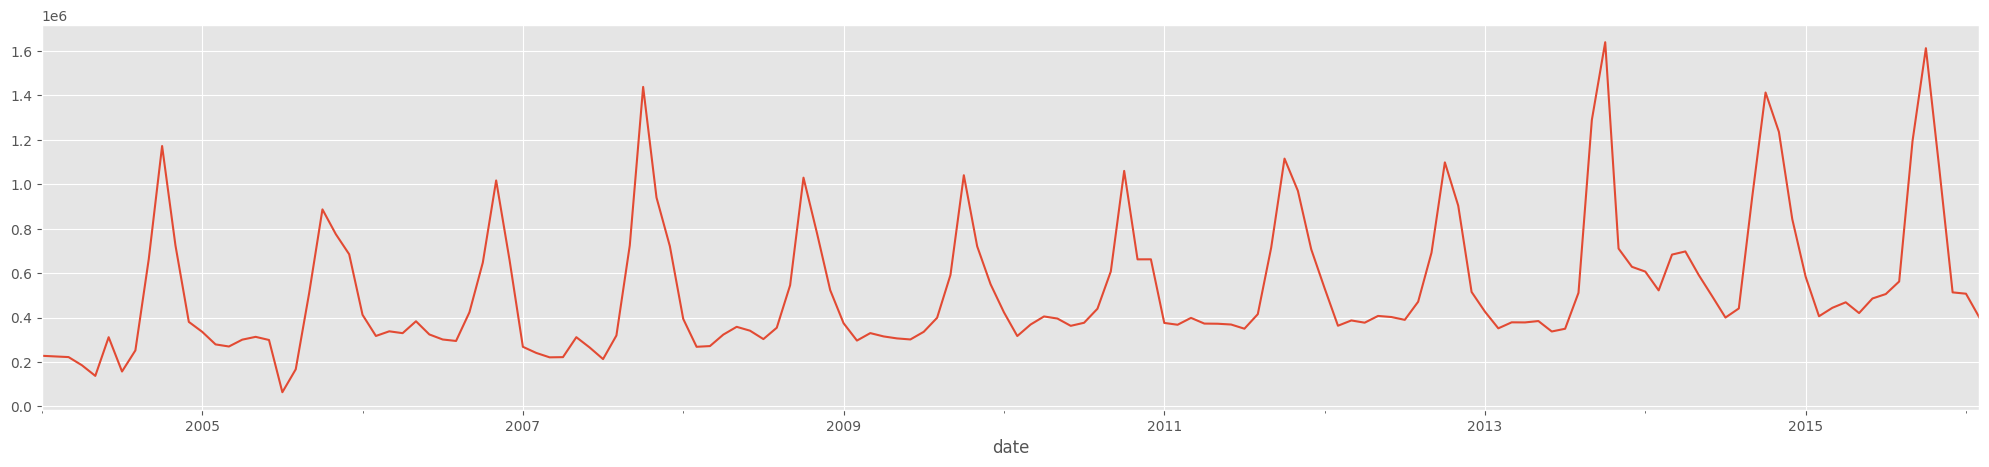

In [9]:
ts.quantity.plot(figsize=(25,5));

## Quiz

Примените критерий Дики-Фуллера

Есть ли в ряде единичные корни?

In [10]:
def check_adfuller(ts):
    stat_adf = adfuller(ts)
    print(f'The Augmented Dicky-Fuller statistic {stat_adf[0]}, \npvalue {stat_adf[1]} \ncritical value {stat_adf[4]}')
    if stat_adf[0] > stat_adf[4]['5%']:
        print('Есть единичные корни - ряд нестационарный')
    else:
        print('Ряд стационарный')

In [11]:
check_adfuller(ts)

The Augmented Dicky-Fuller statistic -0.87800739689695, 
pvalue 0.7951286022098925 
critical value {'1%': -3.480500383888377, '5%': -2.8835279559405045, '10%': -2.578495716547007}
Есть единичные корни - ряд нестационарный


## Quiz

Примените kpss-тест

Является ли ряд стационарным?

In [12]:
from statsmodels.tsa.stattools import kpss

def check_kpss(ts):
    kpss_stat = kpss(ts)
    print(f'The Augmented KPSS statistic {kpss_stat[0]}, \npvalue {kpss_stat[1]} \ncritical value {kpss_stat[3]}')
    if kpss_stat[0] > kpss_stat[3]['5%']:
        print('Отвергаем H0, значит, ряд нестационарный')
    else:
        print('Ряд стационарный')

In [13]:
check_kpss(ts)

The Augmented KPSS statistic 0.8362297823646003, 
pvalue 0.01 
critical value {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Отвергаем H0, значит, ряд нестационарный


<ipython-input-12-326bb33652b7>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat = kpss(ts)


## Quiz

Найдите оптимальное $\lambda$ для преобразования Бокса-Кокса

(отрицательные значения говорят о том, что нужно просто логарифмировать ряд - в этом случае считайте, что $\lambda=0$)

Ответ при необходимости округлите до сотых.

In [14]:
from scipy import stats
from copy import deepcopy
print('real lambda ', stats.boxcox(ts['quantity'])[1])

real lambda  -0.037973926946732316


Примените преобразование Бокса-Кокса с найденным значением $\lambda$. Далее работайте с преобразованным рядом (и к исходному не возвращайтесь!)

In [15]:
ts_boxcox = deepcopy(ts)
ts_boxcox['boxcox'] = stats.boxcox(ts['quantity'])[0]

## Quiz

Постройте измененный ряд. Стала ли дисперсия более однородной визуально?

<Axes: xlabel='date'>

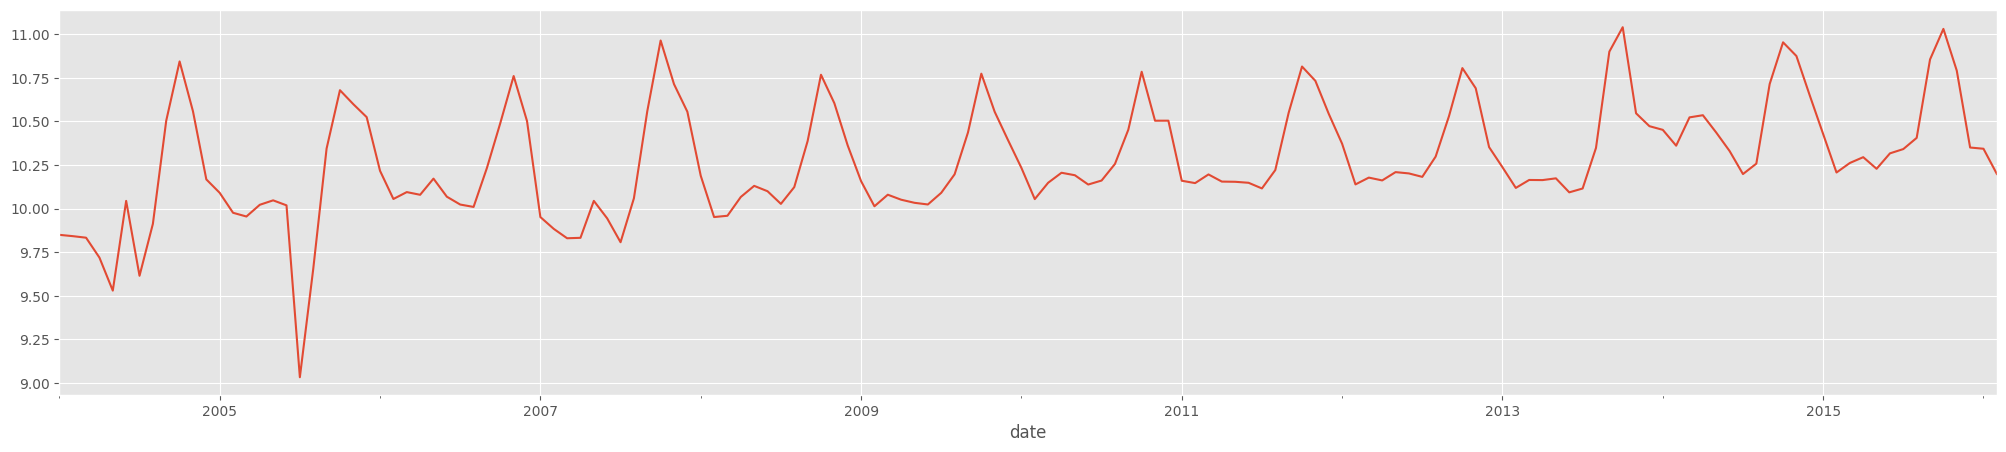

In [16]:
ts_boxcox['boxcox'].plot(figsize=(25, 5))

In [17]:
ts_boxcox

,quantity,boxcox
date,,
2004-01,227832,9.85
2004-02,225133,9.84
2004-03,221952,9.83
2004-04,185150,9.72
2004-05,137390,9.53
...,...,...
2015-10,1612160,11.03
2015-11,1071872,10.79
2015-12,513186,10.35


## Quiz

Визуально в ряде есть небольшой возрастающий тренд.

Продифференцируйте ряд и примените к результату kpss-тест.

Стал ли ряд стационарным?

In [ ]:
dif_ts = (ts_boxcox['boxcox'] - ts_boxcox['boxcox'].shift(1))[1:]

<Axes: xlabel='date'>

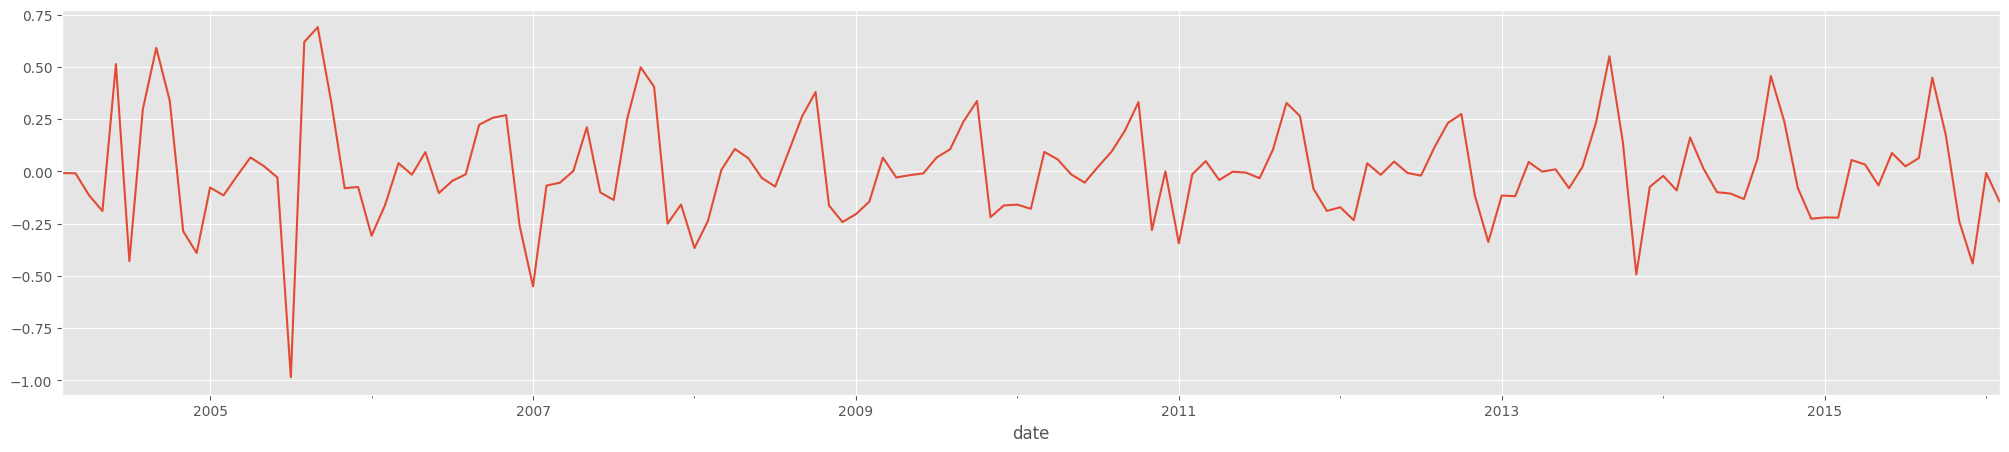

In [29]:
dif_ts.plot(figsize=(25,5))

In [30]:
check_kpss(dif_ts)

The Augmented KPSS statistic 0.07455480697024656, 
pvalue 0.1 
critical value {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
Ряд стационарный


<ipython-input-12-326bb33652b7>:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat = kpss(ts)


Для продифференцированного ряда постройте графики ACF и PACF.

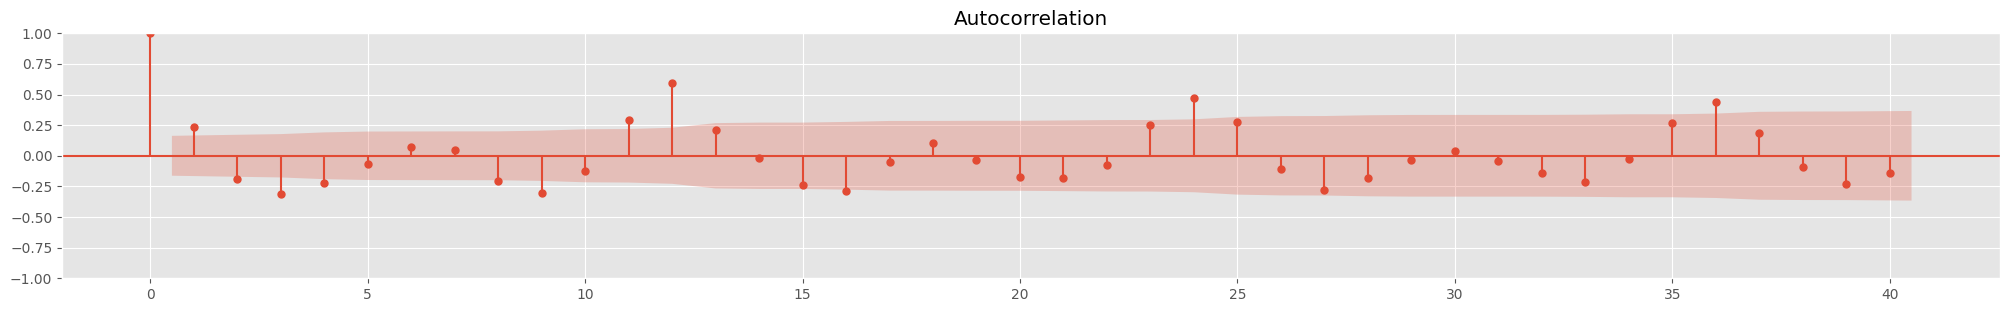

In [31]:
import statsmodels.api as sm

fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dif_ts, lags=40, ax = ax1);

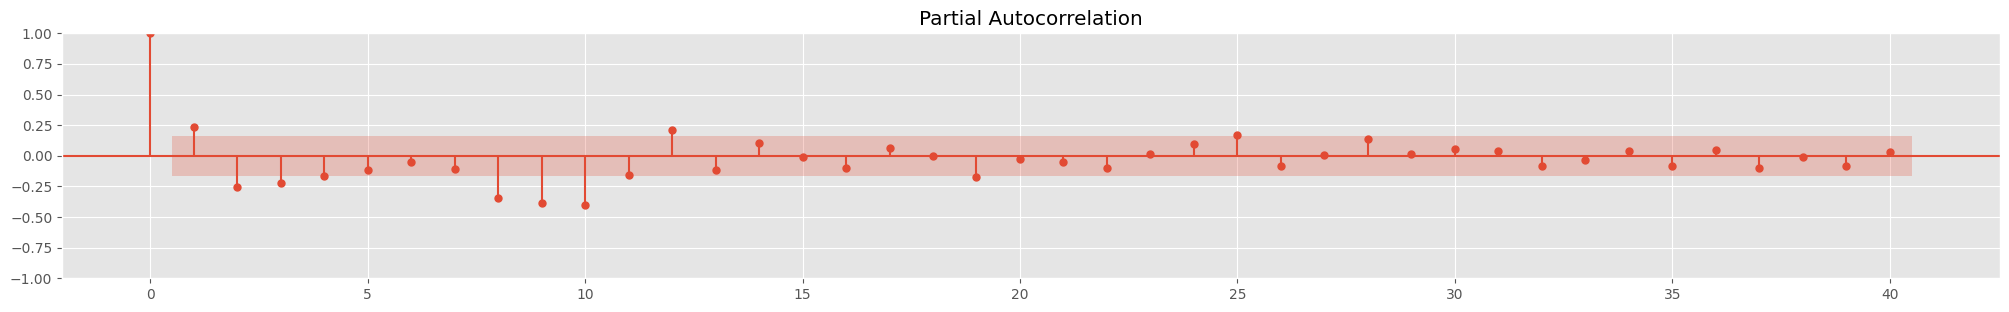

In [33]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_pacf(dif_ts, lags=40, ax = ax1);

## Quiz

По построенным графикам определите значения $p$ и $q$ для модели ARIMA/SARIMAX.

В диапазоны значений входят все значения от 0 до максимального значимого лага за период (сам лаг периода уже не учитывается).

Подсказка: по графикам диапазоны значений $p$ и $q$ получаются одинаковыми. Чему равно максимальное значение из полученного диапазона.

## Обучение модели SARIMAX

Разобъем данные на train, val, test.

* train - первые 65% данных

* val - следующие 20% данных

* test - последние 15% данных

In [34]:
train_length = int(len(ts) * 0.65)
val_length = int(len(ts) * 0.2)

train = ts[:train_length]
val = ts[train_length:train_length+val_length]
test = ts[train_length+val_length:]

train.shape, val.shape, test.shape

((94, 1), (29, 1), (23, 1))

## Quiz

Среди найденных диапазонов $p$ и $q$ подберите оптимальную тройку $(p,d,q)$ ($d$ нашли выше, когда дифференцировали ряд и смотрели на результат) с помощью вложенного цикла.

В цикле обучайте модель SARIMAX на train и смотрите AIC на val.

In [40]:
best_score, best_cfg = float("inf"), None
p = range(0,12)
q = range(0,12)

for pv in p:
    for qv in q:
        order = (pv,1,qv)
        try:
            model = sm.tsa.statespace.SARIMAX(train['quantity'], order=order, enforce_invertibility=True, enforce_stationarity=True).fit()
            y_hat = model.predict(start = test.index[0], end = test.index[-1])
            if model.aic < best_score:
                    best_score, best_cfg = model.aic, order
                    print('SARIMAX%s AIC=%.3f' % (order, model.aic))
        except:
            continue
print('Best SARIMAX%s AIC=%.3f' % (best_cfg, best_score))


SARIMAX(0, 1, 0) AIC=2552.655
SARIMAX(0, 1, 1) AIC=2550.475
SARIMAX(0, 1, 3) AIC=2533.144
SARIMAX(1, 1, 4) AIC=2532.328
SARIMAX(1, 1, 5) AIC=2527.900
SARIMAX(2, 1, 2) AIC=2527.336
SARIMAX(2, 1, 3) AIC=2524.717
SARIMAX(5, 1, 5) AIC=2515.767
SARIMAX(5, 1, 7) AIC=2513.359
SARIMAX(6, 1, 7) AIC=2510.707
SARIMAX(7, 1, 5) AIC=2507.052
SARIMAX(8, 1, 5) AIC=2500.200
SARIMAX(9, 1, 4) AIC=2498.144
SARIMAX(9, 1, 6) AIC=2496.614
SARIMAX(10, 1, 1) AIC=2494.619
SARIMAX(10, 1, 2) AIC=2492.095
SARIMAX(11, 1, 0) AIC=2486.279
SARIMAX(11, 1, 1) AIC=2485.236
Best SARIMAX(11, 1, 1) AIC=2485.236


## Quiz

Обучите на train модель с найденными (p,d,q), выведите на экран AIC - ответ округлите до сотых.

In [41]:
model = sm.tsa.statespace.SARIMAX(train['quantity'], order=(11,1,1),enforce_invertibility=True, enforce_stationarity=True).fit()
model.aic

2485.2361405663764

Сделайте прогноз на **test**.

In [42]:
y_hat = model.predict(start = test.index[0], end = test.index[-1])

In [54]:
y_hat.values

array([408155.31521885, 444068.24603923, 397356.36433078, 340188.19902715,
       430770.8463589 , 681601.7083643 , 848451.07219173, 802650.25255721,
       672573.47923361, 520316.59157688, 437668.62924703, 392627.13148589,
       423236.14945921, 453142.64293915, 402908.26526054, 351152.28029449,
       438673.8693944 , 654398.48267833, 800641.99024118, 784231.43497267,
       676616.16620311, 541821.91651572, 447207.17240369])

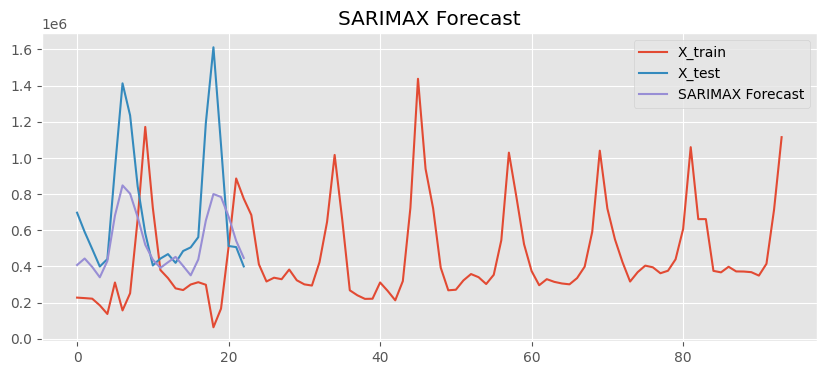

RMSE = 282926.503


In [55]:
from sklearn.metrics import mean_squared_error
plt.figure(figsize=(10,4))
plt.plot(train['quantity'].values, label='X_train')
plt.plot(test['quantity'].values, label='X_test')
plt.plot(y_hat.values, label='SARIMAX Forecast')
plt.legend(loc='best')
plt.title('SARIMAX Forecast')
plt.show()
print('RMSE = %.3f' % mean_squared_error(test['quantity'], y_hat) ** 0.5)

## Quiz

Нарисуйте правильный ответ на test и прогноз на test. Вычислите RMSE на test. Ответ округлите до сотых.

In [ ]:
# ваш код здесь

По графикам ACF и PACF определите примерные диапазоны для P и Q, найдите S.

Нулевые значения также рассматривайте.

Зафиксируйте найденные ранее (p,d,q). Подберите в цикле аналогично подбору для $p, q$ оптимальные значения из найденных диапазонов.

D перебирайте в диапазоне {0, 1}.

In [ ]:
# ваш код здесь


Обучите на train модель с найденными (p,d,q), (P,D,Q,S),выведите на экран AIC - ответ округлите до сотых.

In [ ]:
# ваш код здесь

Сделайте прогноз на test.

In [ ]:
# ваш код здесь

## Quiz

Нарисуйте правильный ответ на test и прогноз на test. Вычислите RMSE на test. Ответ округлите до сотых.

In [ ]:
# ваш код здесь

## Quiz

Удалось ли добиться с помощью настройки гиперпараметров SARIMAX модели с хорошей предсказательной силой?

## Бонус (не проверяется)

Попробуйте добавить экзогенных факторов в модель

In [ ]:
# ваш код здесь